In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import numpy as np
import time
import pickle as pkl
import sys

sys.path.insert(0, '..')
from livexiv.efficient_eval import *

m = 5 #number of models to re-evaluate at each step
name = 'tqa' #'tqa' or 'vqa'

Loading and organizing the data

In [5]:
factor = 10
names = ['VQA','TQA']
data_names = ['vqa','tqa']
models_names = ['InstructBLIP-7B',
                'InternLM-Xcomposer2.5-7B',
                'InternVL2-2B',
                'InternVL2-8B',
                'LLaVA-1.6-Mistral-7B',
                'LLaVA-OneVision-Qwen2-7B',
                'LLaVA-1.5-13B',
                'LLaVA-1.6-7B',
                'LLaVA-1.6-34B',
                'Mantis-LLama3-8B',
                'Phi3v',
                'InternLM-Xcomposer2-4KHD-7B',
                'Idefics2-8B',
                'Claude-Sonnet',
                'Qwen2-VL',
                'GPT-4o',
                'Idefics3']

data = {}
data_sizes = {}
Ys = {}
indices = {}
counts = {}

for name in data_names:
    data[name] = np.load(f"../data/{name}_by_domain_paper_demo.pkl", allow_pickle=True)
    data_sizes[name] = []
    Ys[name] = {0:[],1:[],2:[]}
    indices[name] = {0:[],1:[],2:[]}
    counts[name] = {0:0, 1:0, 2:0}
    
    for k in data[name].keys():
        papers = np.unique(list(data[name][k].keys())).tolist()
        delta = int((len(papers)-len(papers)/factor)/2)
        mu = int(len(papers)/factor)
        d = {}
        d[0] = np.hstack([data[name][k][p] for p in papers[:mu]])
        d[1] = np.hstack([data[name][k][p] for p in papers[mu:(mu+delta)]])
        d[2] = np.hstack([data[name][k][p] for p in papers[(mu+delta):]])
        data_sizes[name].append([d[0].shape[1], d[1].shape[1], d[2].shape[1]])
    
        for j in [0,1,2]:
            Ys[name][j].append(d[j])
            indices[name][j].append(list(range(counts[name][j],counts[name][j]+d[j].shape[1])))
            counts[name][j] += d[j].shape[1]
    
    for j in [0,1,2]:
        Ys[name][j] = np.hstack(Ys[name][j])

(1) Evaluating models on the first version of LiveXiv excluding the models below

In [6]:
models_to_delete = [15, 16]

In [7]:
models = {}
models[0] = list(range(0,len(models_names)))
models[0] = [m for m in models[0] if m not in models_to_delete]
Y_list = [Ys[name][0][models[0]]]
M_list = [models[0]]
reval_models, _ = EfficEval(Y_list, M_list, m)

Choosing $m$ models to re-evaluate

In [8]:
[models_names[m] for m in reval_models], reval_models

(['InstructBLIP-7B',
  'InternLM-Xcomposer2.5-7B',
  'InternVL2-8B',
  'LLaVA-1.5-13B',
  'Claude-Sonnet'],
 [0, 1, 3, 6, 13])

(2) Evaluating models in the second version of LiveXiv 

In [9]:
models[1] = reval_models + models_to_delete
Y_list += [Ys[name][1][models[1]]]
M_list += [models[1]]
reval_models, Y_hat = EfficEval(Y_list, M_list, m)

Checking predictive performance of our efficient evaluation method

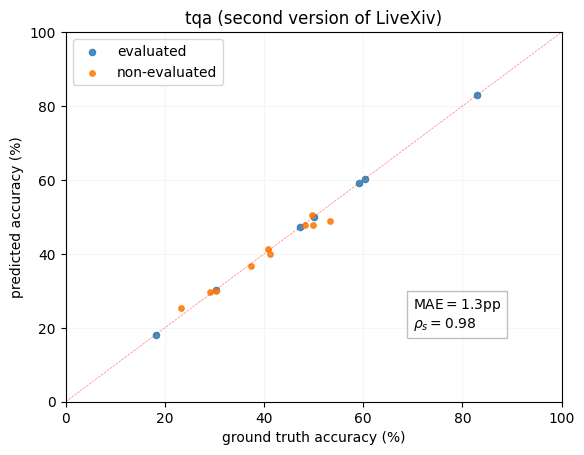

In [10]:
acc = 100*Ys[name][1].mean(1)
acc_hat = 100*Y_hat[1].mean(1)

ind = np.zeros(len(models_names)).astype(bool)
ind[models[1]] = True
plt.scatter(acc[ind], acc_hat[ind], s=20, alpha=.80, label='evaluated')
plt.scatter(acc[~ind], acc_hat[~ind], s=15, alpha=.90, label='non-evaluated')
plt.plot([0, 100], [0, 100], 'r--', lw=.5, alpha=.5)
text = f'MAE$=${np.abs(acc-acc_hat)[~ind].mean():.1f}pp\n$\\rho_s=${spearmanr(acc, acc_hat).statistic:.2f}'
plt.text(70, 20, text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.5))

plt.xlabel('ground truth accuracy (%)')
plt.ylabel('predicted accuracy (%)')
plt.xlim(0,100)
plt.ylim(0,100)
plt.title(name+" (second version of LiveXiv)")
plt.grid(alpha=.1)

plt.legend()
plt.show()

Checking $m$ models to re-evaluate

In [11]:
[models_names[m] for m in reval_models], reval_models

(['InstructBLIP-7B',
  'InternVL2-8B',
  'LLaVA-1.6-7B',
  'InternLM-Xcomposer2-4KHD-7B',
  'Claude-Sonnet'],
 [0, 3, 7, 11, 13])

(3) Evaluating models in the third version of LiveXiv 

In [12]:
models[2] = reval_models
Y_list += [Ys[name][2][models[2]]]
M_list += [models[2]]
reval_models, Y_hat = EfficEval(Y_list, M_list, m)

Checking predictive performance of our efficient evaluation method

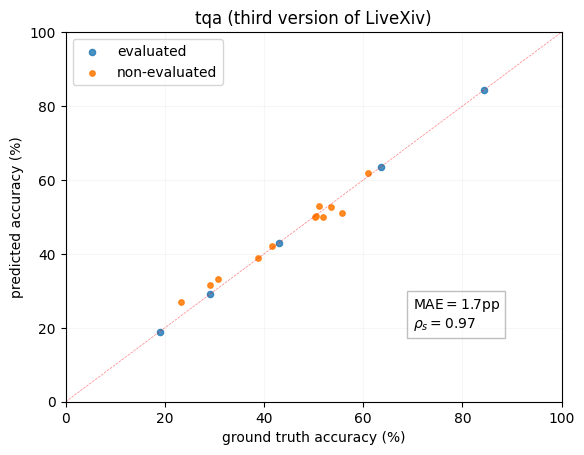

In [13]:
acc = 100*Ys[name][2].mean(1)
acc_hat = 100*Y_hat[2].mean(1)

ind = np.zeros(len(models_names)).astype(bool)
ind[models[2]] = True
plt.scatter(acc[ind], acc_hat[ind], s=20, alpha=.80, label='evaluated')
plt.scatter(acc[~ind], acc_hat[~ind], s=15, alpha=.90, label='non-evaluated')
plt.plot([0, 100], [0, 100], 'r--', lw=.5, alpha=.5)
text = f'MAE$=${np.abs(acc-acc_hat)[~ind].mean():.1f}pp\n$\\rho_s=${spearmanr(acc, acc_hat).statistic:.2f}'
plt.text(70, 20, text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.5))

plt.xlabel('ground truth accuracy (%)')
plt.ylabel('predicted accuracy (%)')
plt.xlim(0,100)
plt.ylim(0,100)
plt.title(name+" (third version of LiveXiv)")
plt.grid(alpha=.1)

plt.legend()
plt.show()

Checking $m$ models to re-evaluate

In [14]:
[models_names[m] for m in reval_models], reval_models

(['InstructBLIP-7B',
  'InternVL2-8B',
  'Idefics2-8B',
  'Claude-Sonnet',
  'Idefics3'],
 [0, 3, 12, 13, 16])